In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.integrate as spi

# Computational Design of Microbial Communities - part 1

In this tutorial we will start by learning how we can build mathematical models of microbial communities and understanding the huge number of possible ways that we can construct synthetic communities -- and therefore the need for computational approaches to explore this space. We will then develop an understanding of a machine learning technique called Approximate Bayesian Computation (ABC) by implementing a simple ABC algorithm. Finally, we will apply our ABC algorithm to a simple community model space to find the best way to create co-existing communities.  

## Modelling Microbial Communities
Communities are composed of individual strains that grow and die (or are lost through dilution). We can write how each population changes using an ordinary differential equation

$$ \frac{d x}{d t} = (\mu - \omega) x $$

where $x$ is the population size, $\mu$ is the growth rate, and $\omega$ is the death/loss rate. 

We can find the steady states (where an equilibrium is reached) by setting the left-hand-side of this equation to $0$ i.e. there is no change in the system. If you do some algebra you should see that we have a steady state when $x=0$ or when $\mu = \omega$. If $\mu$ and $\omega$ were constants and $\mu \neq \omega$ we have exponential growth or decay, depending on whether $\mu$ or $\omega$ is larger -- which is biologically and physically infeasible.

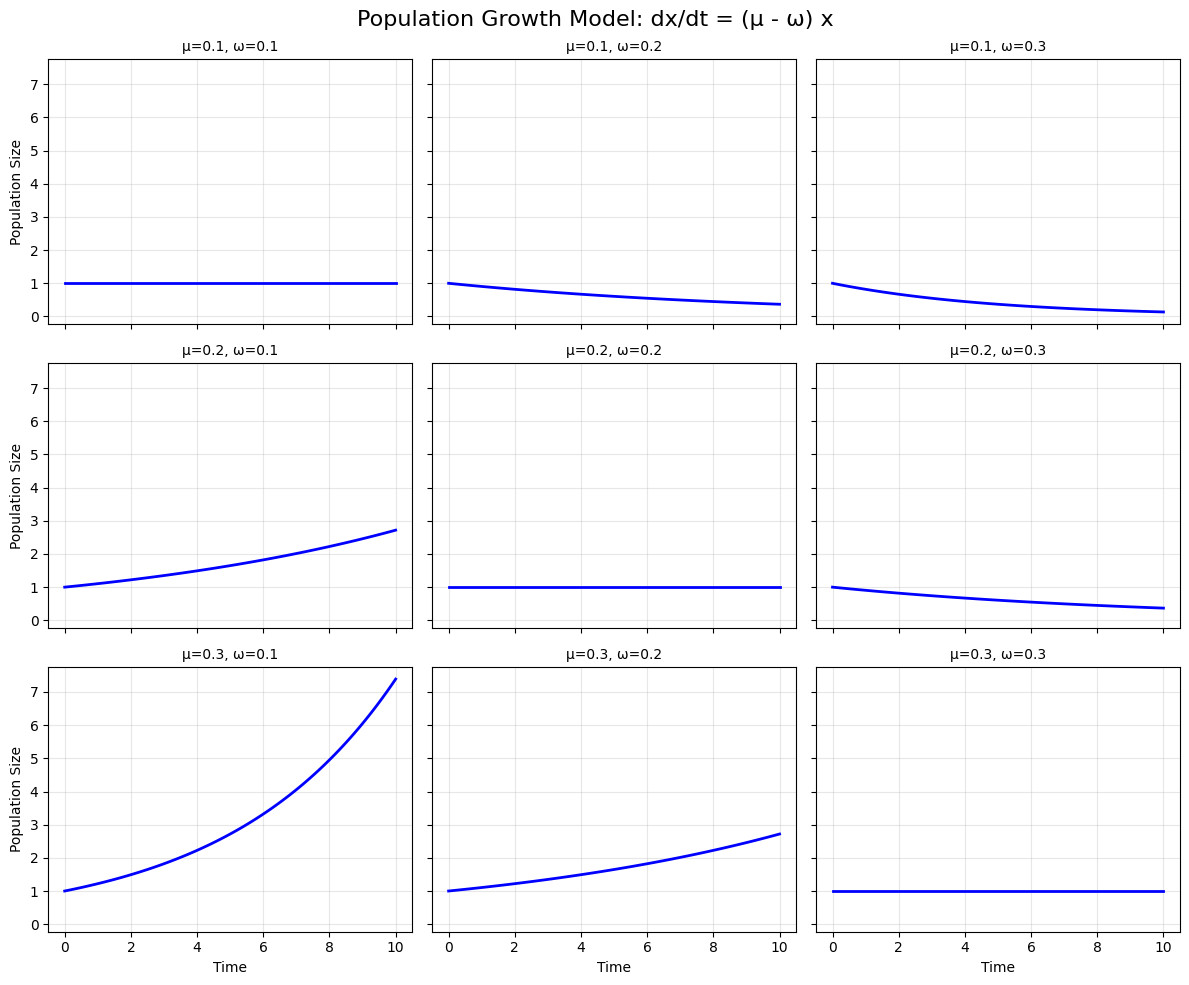

In [2]:
# define a function to calculate the growth rate
def growth_model(y, t, params):
    # unpack parameters
    mu, omega = params

    # unpack state variables
    x = y[0]  # population size

    dx_dt = (mu - omega) * x
    return [dx_dt]

# define the parameter ranges
mu_values = np.linspace(0.1, 0.3, 3)  # growth rate
omega_values = np.linspace(0.1, 0.3, 3)

# create a DataFrame to store the results
results = pd.DataFrame(columns=['mu', 'omega', 'population_size'])

# set up the plot
fig, axes = plt.subplots(len(omega_values), len(mu_values), 
                        figsize=(12, 10), sharex=True, sharey=True)
fig.suptitle('Population Growth Model: dx/dt = (μ - ω) x', fontsize=16)

# loop through the parameter grid and solve the ODE for each set of parameters
for i, mu in enumerate(mu_values):
    for j, omega in enumerate(omega_values):
        # parameters
        params = (mu, omega)
        # initial condition
        y0 = [1]  # initial population size
        # time points
        t = np.linspace(0, 10, 100)
        # solve the ODE
        solution = spi.odeint(growth_model, y0, t, args=(params,))    
        # extract the population trajectory
        population_size = solution[:, 0]

        # Plot on the corresponding subplot
        ax = axes[i, j] if len(omega_values) > 1 else axes[j]
        ax.plot(t, population_size, 'b-', linewidth=2)
        ax.set_title(f'μ={mu:.1f}, ω={omega:.1f}', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add labels only to edge subplots
        if i == len(omega_values) - 1:  # Bottom row
            ax.set_xlabel('Time')
        if j == 0:  # Left column
            ax.set_ylabel('Population Size')

plt.tight_layout()
plt.show()


### Logistic Growth

In reality these rates are not constant, but are functions of other variables that we can capture in our models. The simplest form that we may have seen is logistic growth

$$ \frac{d x}{d t} = r x (1 - \frac{x}{C}) $$

where $C$ is the carrying capacity and $r$ is the constant of proportionality. Again, if we analyse the model, you should see that we have a steady state when $x =  C$

$$ 0 = r x (1 - \frac{x}{C}) $$
$$ r x = \frac{r x^2}{C} $$
$$ x = C $$

We could rewrite the logistic model into a form that is closer to our original model

$$ \frac{d x}{d t} = (\mu - \omega(x)) x $$

Here $\mu = r$, and $\omega(x) = \frac{r}{C} x$. So now our death rate is no longer constant but a function of the population size $x$ itself.

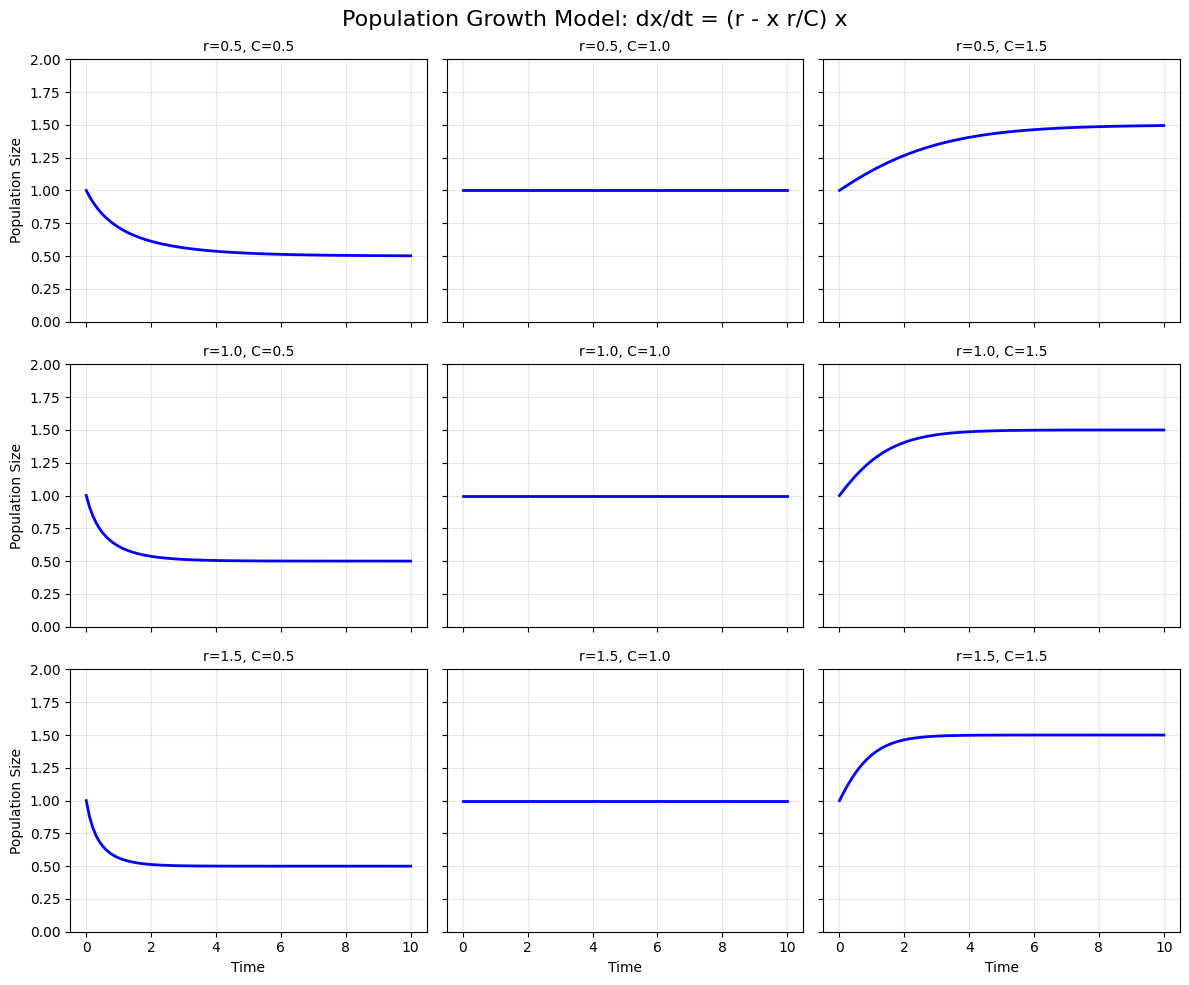

In [3]:
# define a function to calculate the growth rate
def growth_model(y, t, params):
    # unpack parameters
    r, C = params

    # unpack state variables
    x = y[0]  # population size

    dx_dt = (r - x * r/C) * x
    return [dx_dt]

# define the parameter ranges
r_values = np.linspace(0.5, 1.5, 3)  # growth rate
C_values = np.linspace(0.5, 1.5, 3)

# create a DataFrame to store the results
results = pd.DataFrame(columns=['r', 'C', 'population_size'])

# set up the plot
fig, axes = plt.subplots(len(C_values), len(r_values), 
                        figsize=(12, 10), sharex=True, sharey=True)
fig.suptitle('Population Growth Model: dx/dt = (r - x r/C) x', fontsize=16)

# loop through the parameter grid and solve the ODE for each set of parameters
for i, r in enumerate(r_values):
    for j, C in enumerate(C_values):
        # parameters
        params = (r, C)
        # initial condition
        y0 = [1]  # initial population size
        # time points
        t = np.linspace(0, 10, 100)
        # solve the ODE
        solution = spi.odeint(growth_model, y0, t, args=(params,))    
        # extract the population trajectory
        population_size = solution[:, 0]

        # Plot on the corresponding subplot
        ax = axes[i, j] if len(C_values) > 1 else axes[j]
        ax.plot(t, population_size, 'b-', linewidth=2)
        ax.set_title(f'r={r:.1f}, C={C:.1f}', fontsize=10)
        ax.set_ylim(0, 2.0)  # Adjust y-axis limits for better visibility
        ax.grid(True, alpha=0.3)
        
        # Add labels only to edge subplots
        if i == len(C_values) - 1:  # Bottom row
            ax.set_xlabel('Time')
        if j == 0:  # Left column
            ax.set_ylabel('Population Size')

plt.tight_layout()
plt.show()


### Generalised Lotka-Volterra equation

There is no biological mechanism imposing the limits in this model -- we cannot say that the population is limited by running out of a resource or space etc. Instead we have the abstract concept that there is some negative interaction between the organisms themselves.

We can use this idea of abstract interactions to begin to build a model of a community. The generalised Lotka-Volterra (gLV) equations model the dynamics of $n$ interacting populations $x_1, x_2, ... x_n$. The change in the *i*th population is modelled as

$$ \frac{d x_i}{d t} = (r_i + \sum_{j=1}^{n} a_{i,j} x_j) x_i $$

where $r_i$ is the growth constant of population $x_i$, and $a_{i,j}$ is the interaction constant between population $x_i$ and $x_j$. 

So here, just like the logistic growth model, we have a constant $r_i$ describing the intrinsic growth rate for each species. However, where the logistic model had a death rate $\omega(x)$ that was a function solely of its own population level, here we have a rate that is dependant on the population levels of all species. Each $a_{i,j}$ term is a constant that tells us the strength of the interaction. In fact, these constants can be positive or negative, which opens the possibility of not just a death rate that is dependent on other strains, but co-opperative growth as well.

We tend to use linear algebra notation for the gLV

$$ \mathbf{x}' = (\mathbf{r} + \mathbf{A x}) \mathbf{x} $$

where $\mathbf{x}$ is the vector of our species counts, $\mathbf{r}$ is a vector of the intrinsic growth rates for each species, and $\mathbf{A}$ is the interaction matrix.

The number of parameters in the gLV model is $n + n^2$, where $n$ is the number of interacting populations.

The canonical ecological interactions (neutralism, commensalism, ammensalism, mutualism, competition, and predator-prey) are achievable by changing off-diagonal parameters in the interactoin matrix $\mathbf{A}$.

In [4]:
# Example 1: Two-species system with different interaction types

# Define different interaction scenarios
scenarios = {
    'Competition': {
        'r': np.array([0.5, 0.5]),
        'A': np.array([[-0.1, -0.1],   # species 1 inhibited by species 2
                       [-0.2, -0.2]])   # species 2 inhibited by species 1
    },
    'Mutualism': {
        'r': np.array([0.5, 0.5]),
        'A': np.array([[-0.1, 0.1],    # species 1 benefits from species 2
                       [0.2, -0.2]])    # species 2 benefits from species 1
    },
    'Predator-Prey': {
        'r': np.array([0.5, 0.5]),
        'A': np.array([[-0.1, -0.1],   # species 1 inhibited by species 2
                       [0.2, -0.2]])    # species 2 benefits from species 1
    },
    'Commensalism': {
        'r': np.array([0.5, 0.5]),
        'A': np.array([[-0.1, 0.0],    # species 1 unaffected by species 2
                       [0.2, -0.2]])    # species 2 benefits from species 1
    },
    'Ammensalism': {
        'r': np.array([0.5, 0.5]),
        'A': np.array([[-0.1, 0.0],    # species 1 unaffected by species 2
                       [-0.2, -0.2]])    # species 2 inhibited by species 1
    },
    'Neutralism': {
        'r': np.array([0.5, 0.5]),
        'A': np.array([[-0.1, 0.0],    # species 1 unaffected by species 2
                       [0.0, -0.2]])    # species 2 unaffected by species 1
    }
}


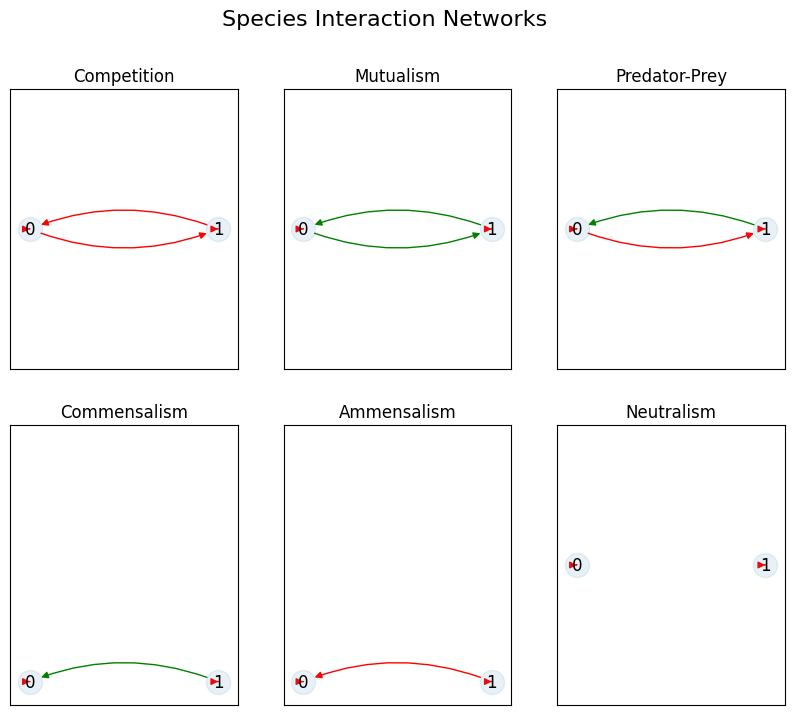

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools as it

def plot_interaction_network_nx(ax, A, species_names=None, title="Species Interaction Network", 
                               pos_layout='circular', node_size=1000, font_size=12):
    """
    Plot a network diagram showing species interactions using NetworkX.
    
    Parameters:
    ax: matplotlib axis object
    A: interaction matrix (n x n numpy array)
    species_names: list of species names (optional)
    title: plot title
    pos_layout: layout type ('circular', 'spring', 'shell', etc.)
    node_size: size of nodes
    font_size: font size for labels
    """
    n_species = A.shape[0]
    
    if species_names is None:
        species_names = [i for i in range(n_species)]
    
    # Create directed graph
    # G = nx.DiGraph()
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)

    # Add nodes
    # for i in range(n_species):
    #     G.add_node(i, label=species_names[i])

    # Add edges with weights
    edge_colors = []
    edge_widths = []
    edge_labels = {}
    
    for i in range(n_species):
        for j in range(n_species):
            if A[i, j] != 0:  # Skip zero interactions
                G.add_edge(i, j, weight=A[i, j])
                # Color based on interaction type
                if A[i, j] > 0:
                    edge_colors.append('green')
                else:
                    edge_colors.append('red')
                # Width proportional to absolute weight
                edge_widths.append(abs(A[i, j]) * 5)
                edge_labels[(i, j)] = f'{A[i, j]:.2f}'

    # Choose layout
    if pos_layout == 'circular':
        pos = nx.circular_layout(G)
    elif pos_layout == 'spring':
        pos = nx.spring_layout(G, k=0.5, iterations=50)
    elif pos_layout == 'shell':
        pos = nx.shell_layout(G)
    else:
        pos = nx.circular_layout(G)  # default
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, alpha=0.1)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, ax=ax)
    # nx.draw_networkx_labels(G, pos, node_labels, font_size=font_size, 
    #                        font_weight='bold', ax=ax)
    
    # Draw edges    
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.2] * 4)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, 
                        #    width=edge_widths, 
                          connectionstyle=connectionstyle, ax=ax)
    
    # Draw edge labels
    # nx.draw_networkx_edge_labels(G, pos, edge_labels, horizontalalignment='right', verticalalignment='top', ax=ax)
    
    ax.set_title(title, fontsize=12)
    # ax.axis('off')

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Species Interaction Networks', fontsize=16)

for idx, (scenario_name, params) in enumerate(scenarios.items()):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    A = params['A']
    plot_interaction_network_nx(ax, A, title=scenario_name, pos_layout='shell')



C:\Users\AJFed\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\bdf.py:232: LinAlgWarning: Diagonal number 2 is exactly zero. Singular matrix.
  return lu_factor(A, overwrite_a=True)


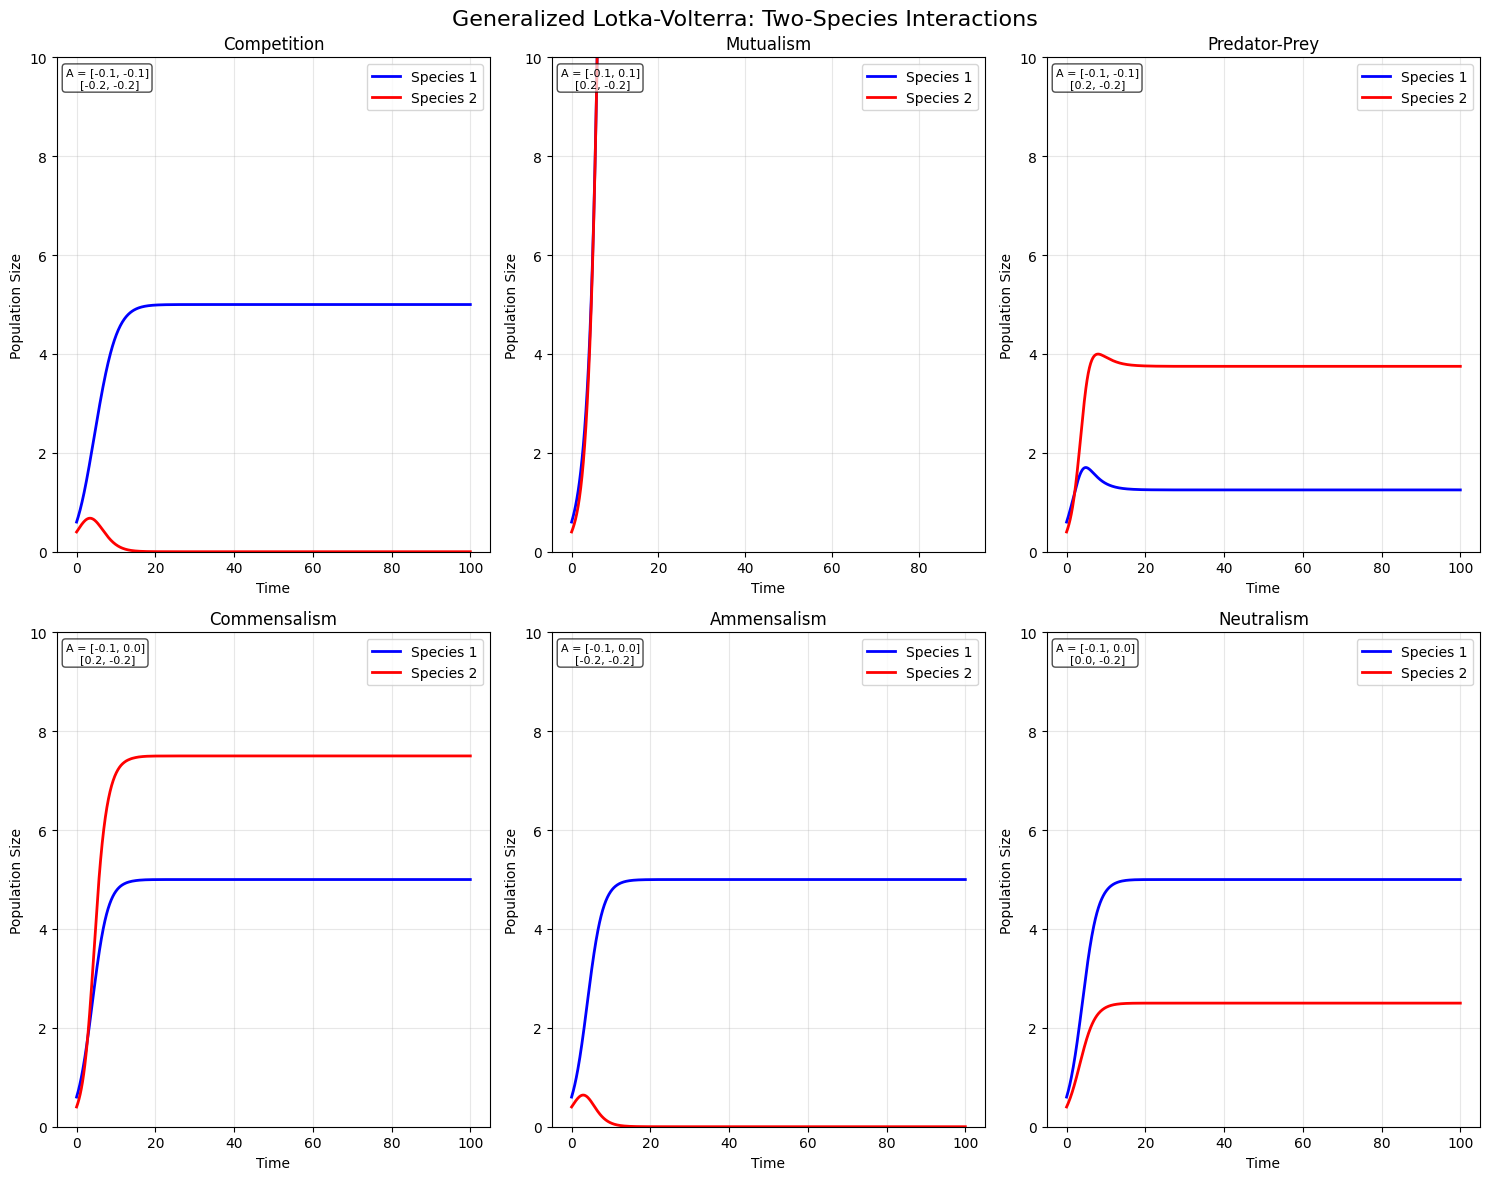

In [6]:
# Generalized Lotka-Volterra (gLV) model implementation
def glv_model(t, y, r, A):
    """
    Generalized Lotka-Volterra model: dx/dt = (r + A*x) * x
    
    Parameters:
    y: current state vector (species abundances)
    t: time
    r: intrinsic growth rates vector
    A: interaction matrix
    """
    x = np.array(y)
    # # Calculate dx/dt = (r + A*x) * x (element-wise multiplication)
    dxdt = (r + np.dot(A, x)) * x
    return dxdt

# Example 1: Two-species system with different interaction types
# Set up parameters for 2-species system
time_points = np.linspace(0, 100, 1001)
initial_conditions = [0.6, 0.4]  # Initial populations

# Create subplots for different scenarios
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Generalized Lotka-Volterra: Two-Species Interactions', fontsize=16)

for idx, (scenario_name, params) in enumerate(scenarios.items()):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    # Solve the gLV system
    solution = spi.solve_ivp(glv_model, (time_points[0], time_points[-1]), initial_conditions, 
                         args=(params['r'], params['A']), t_eval=time_points, method='BDF')
    
    # Plot the trajectories
    ax.plot(solution.t, solution.y[0], 'b-', linewidth=2, label='Species 1')
    ax.plot(solution.t, solution.y[1], 'r-', linewidth=2, label='Species 2')
    ax.set_title(f'{scenario_name}', fontsize=12)
    ax.set_xlabel('Time')
    ax.set_ylabel('Population Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # ax.set_ylim(0, max(2, np.max(solution) * 1.1))
    ax.set_ylim(0, 10)
    
    # Add annotation with interaction matrix A
    A_matrix = params['A']
    matrix_text = f"A = [{A_matrix[0,0]:.1f}, {A_matrix[0,1]:.1f}]\n    [{A_matrix[1,0]:.1f}, {A_matrix[1,1]:.1f}]"
    ax.text(0.02, 0.98, matrix_text, transform=ax.transAxes, fontsize=8, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()


We can perform standard dynamical systems analyses on these equations. For example, looking at phase portraits

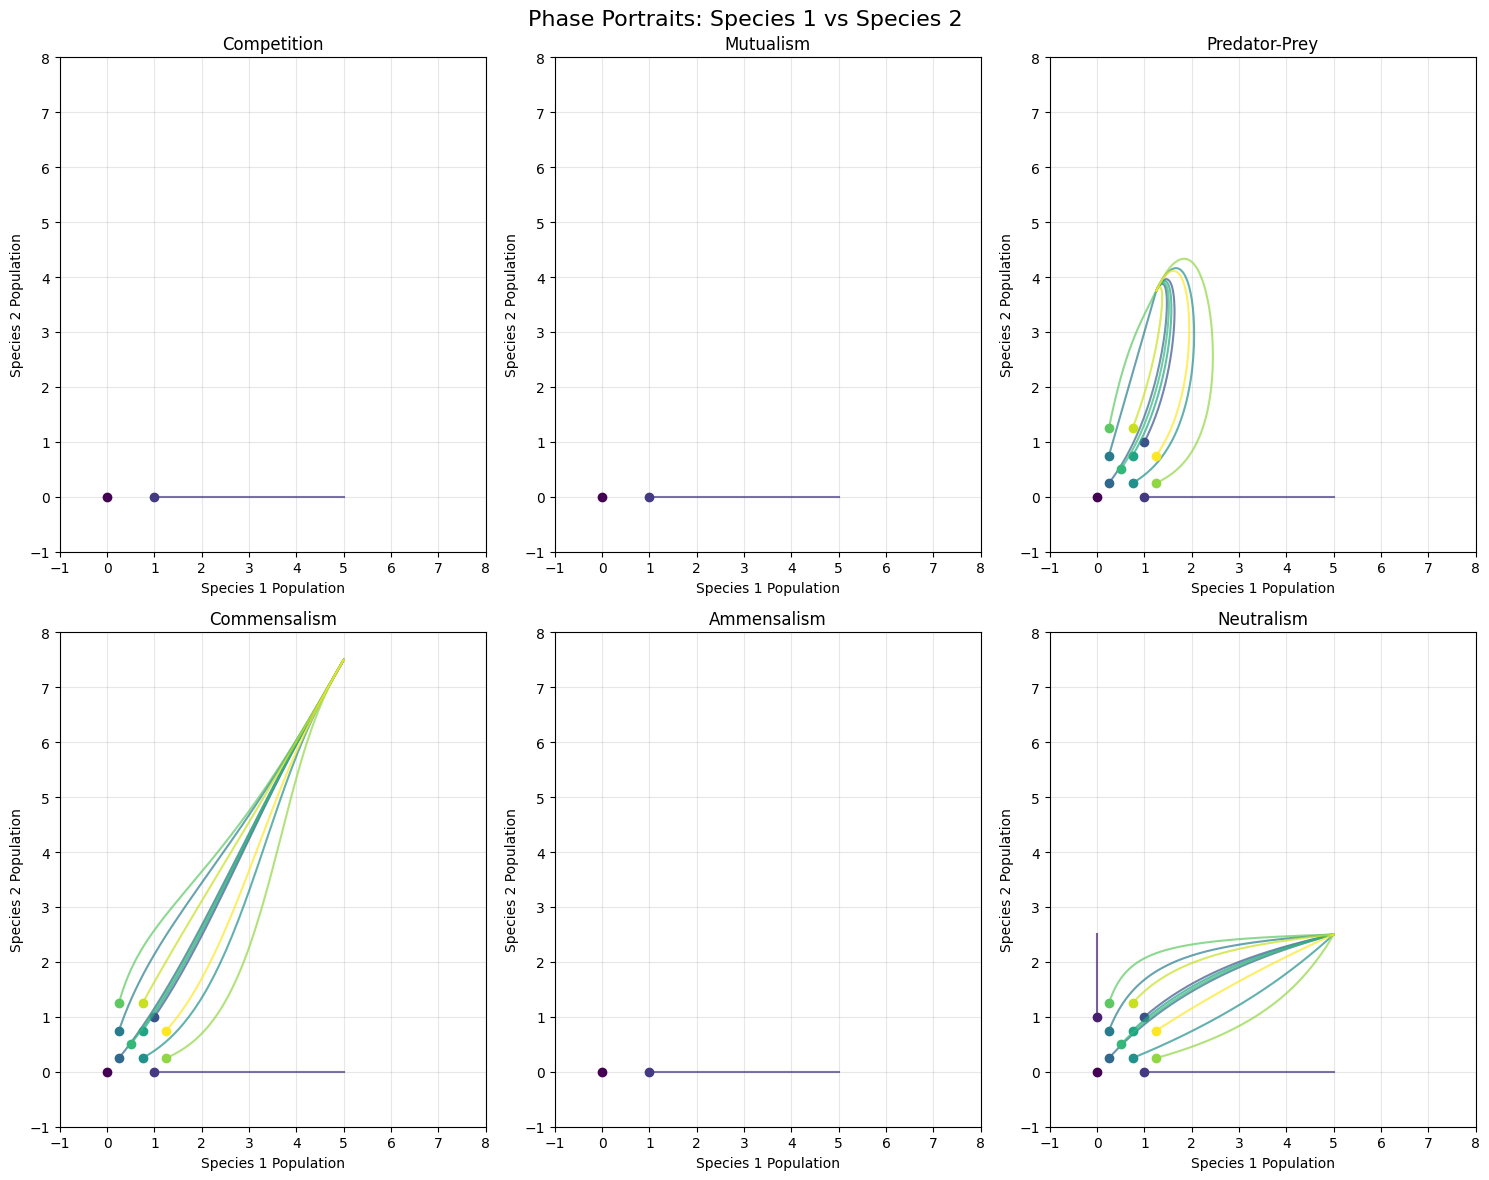

In [7]:
# Example 2: Phase portraits for two-species systems
fig, axes = plt.subplots(2, 3, figsize=(15, 12))
fig.suptitle('Phase Portraits: Species 1 vs Species 2', fontsize=16)

for idx, (scenario_name, params) in enumerate(scenarios.items()):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    # Multiple initial conditions for phase portrait
    initial_conditions_list = [
        [0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0],
        [0.25, 0.25], [0.25, 0.75], [0.75, 0.25], [0.75, 0.75],
        [0.5, 0.5],
        [0.25, 1.25], [1.25, 0.25], [0.75, 1.25], [1.25, 0.75]
    ]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(initial_conditions_list)))
    
    for ic, color in zip(initial_conditions_list, colors):
        try:
            solution = spi.solve_ivp(glv_model, (time_points[0], time_points[-1]), ic, 
                                args=(params['r'], params['A']), t_eval=time_points, method='BDF')
            # Only plot if solution is reasonable (no explosion)
            if np.all(solution.y >= 0) and np.max(solution.y) < 10:
                ax.plot(solution.y[0], solution.y[1], 
                       color=color, alpha=0.7, linewidth=1.5)
                ax.plot(ic[0], ic[1], 'o', color=color, markersize=6)
        except:
            continue
    
    ax.set_title(f'{scenario_name}', fontsize=12)
    ax.set_xlabel('Species 1 Population')
    ax.set_ylabel('Species 2 Population')
    ax.set_xlim(-1, 8)
    ax.set_ylim(-1, 8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Finding equilibria and analysing stability for a given set of parameters.

In [8]:
# Function to analyze equilibrium points
def find_equilibrium(r, A, tolerance=1e-6):
    """
    Find equilibrium points of gLV system by solving (r + A*x) = 0
    for coexistence equilibrium where x > 0
    """
    try:
        # For coexistence equilibrium: A*x = -r, so x = -A^(-1) * r
        x_eq = np.linalg.solve(A, -r)
        # Check if equilibrium is feasible (all populations > 0)
        if np.all(x_eq > tolerance):
            return x_eq, True
        else:
            return x_eq, False
    except np.linalg.LinAlgError:
        return None, False

# Analyze equilibria for our scenarios
for scenario_name, params in scenarios.items():
    eq, feasible = find_equilibrium(params['r'], params['A'])
    if eq is not None:
        print(f"{scenario_name}:")
        print(f"  Equilibrium: [{eq[0]:.2f}, {eq[1]:.2f}]")
        print(f"  Feasible (all positive): {feasible}")
        
        # Check stability using eigenvalues of Jacobian at equilibrium
        if feasible:
            # Jacobian matrix at equilibrium
            J = np.diag(eq) @ params['A']
            eigenvalues = np.linalg.eigvals(J)
            stable = np.all(np.real(eigenvalues) < 0)
            print(f"  Stable: {stable}")
            print(f"  Eigenvalues: {eigenvalues}")
        print()
    else:
        print(f"{scenario_name}: No valid equilibrium found\n")

Competition: No valid equilibrium found

Mutualism: No valid equilibrium found

Predator-Prey:
  Equilibrium: [1.25, 3.75]
  Feasible (all positive): True
  Stable: True
  Eigenvalues: [-0.375 -0.5  ]

Commensalism:
  Equilibrium: [5.00, 7.50]
  Feasible (all positive): True
  Stable: True
  Eigenvalues: [-1.5 -0.5]

Ammensalism:
  Equilibrium: [5.00, -2.50]
  Feasible (all positive): False

Neutralism:
  Equilibrium: [5.00, 2.50]
  Feasible (all positive): True
  Stable: True
  Eigenvalues: [-0.5 -0.5]



We can easily expand to more species simply by expanding $\mathbf{r}$ and $\mathbf{A}$

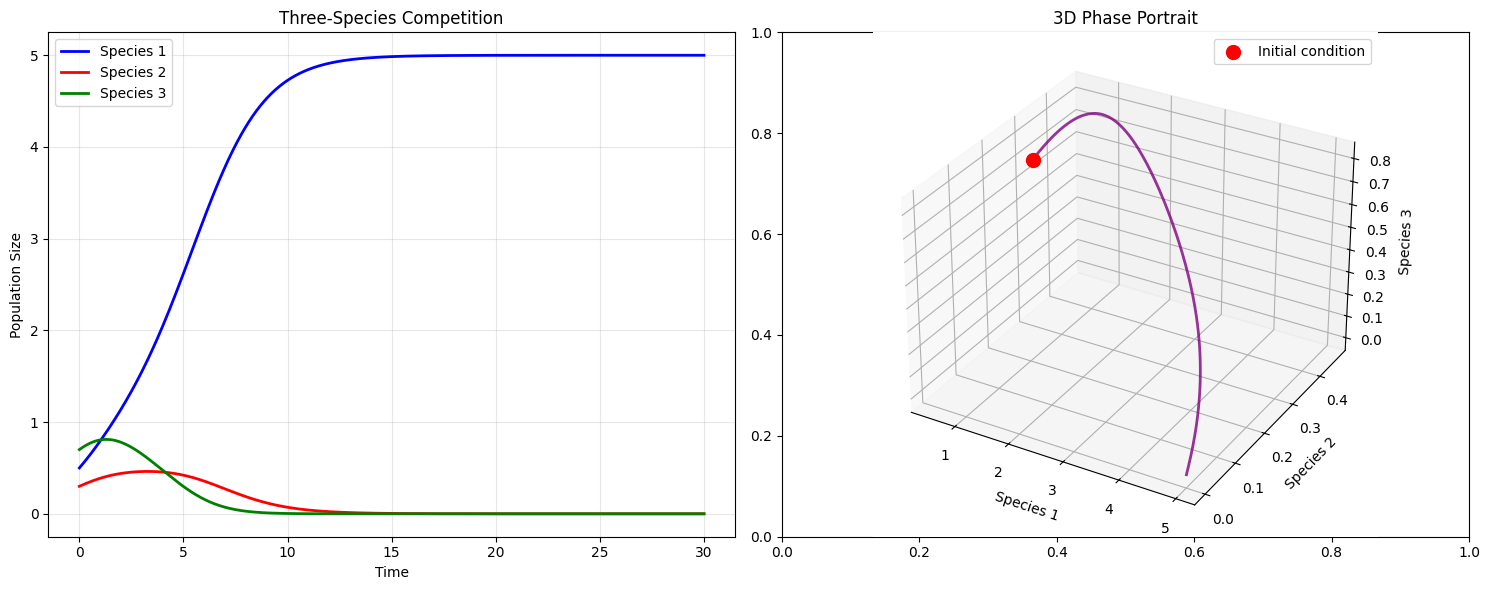

In [9]:
# Example 3: Three-species system
# 3-species competitive system
r_3sp = np.array([1.0, 0.9, 0.8])
A_3sp = np.array([[-0.2, -0.3, -0.4],
                  [-0.3, -0.2, -0.5],
                  [-0.4, -0.5, -0.3]])

initial_3sp = [0.5, 0.3, 0.7]
time_3sp = np.linspace(0, 30, 1000)

solution_3sp = spi.solve_ivp(glv_model, (time_3sp[0], time_3sp[-1]), initial_3sp, args=(r_3sp, A_3sp), t_eval=time_3sp, method='BDF')

# Plot 3-species dynamics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Time series
ax1.plot(solution_3sp.t, solution_3sp.y[0], 'b-', linewidth=2, label='Species 1')
ax1.plot(solution_3sp.t, solution_3sp.y[1], 'r-', linewidth=2, label='Species 2')
ax1.plot(solution_3sp.t, solution_3sp.y[2], 'g-', linewidth=2, label='Species 3')
ax1.set_title('Three-Species Competition')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population Size')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 3D phase portrait
from mpl_toolkits.mplot3d import Axes3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(solution_3sp.y[0], solution_3sp.y[1], solution_3sp.y[2], 
         'purple', linewidth=2, alpha=0.8)
ax2.scatter(initial_3sp[0], initial_3sp[1], initial_3sp[2], 
           color='red', s=100, label='Initial condition')
ax2.set_xlabel('Species 1')
ax2.set_ylabel('Species 2')
ax2.set_zlabel('Species 3')
ax2.set_title('3D Phase Portrait')
ax2.legend()

plt.tight_layout()
plt.show()

The gLV model is able to achieve many dynamics, from stability to oscillations and even chaos

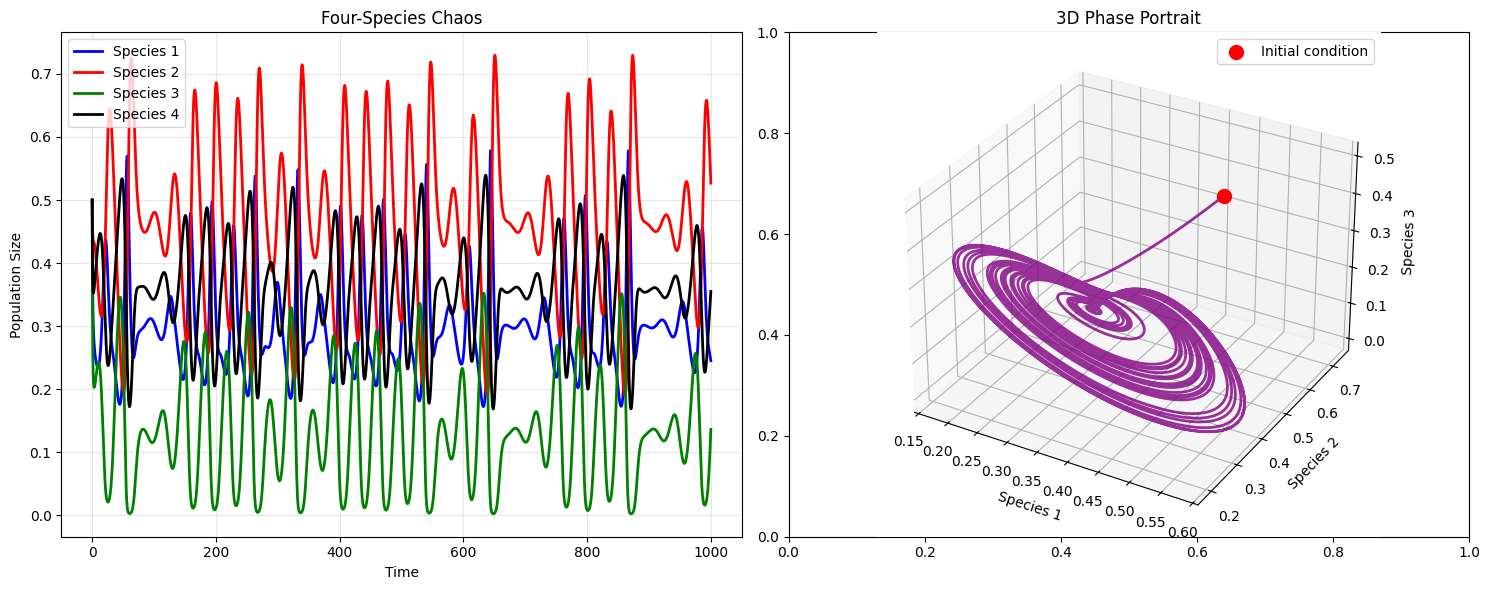

In [10]:
# Example 4: Chaotic 4-species system
r_4sp = np.array([1.0, 0.72, 1.53, 1.27])
# A matrix values from 10.1088/0951-7715/19/10/006
A_4sp = np.array([[1.0, 1.09, 1.52, 0.0],
                  [0.0, 1.0, 0.44, 1.36],
                  [2.33, 0.0, 1.0, 0.47],
                  [1.21, 0.51, 0.35, 1.0]])*-1
A_4sp = (r_4sp * A_4sp.T).T

initial_4sp = [0.5, 0.5, 0.5, 0.5]
time_4sp = np.linspace(0, 1000, 100000)

solution_4sp = spi.solve_ivp(glv_model, (time_4sp[0], time_4sp[-1]), initial_4sp, args=(r_4sp, A_4sp), t_eval=time_4sp, method='BDF')

# Plot 4-species dynamics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Time series
ax1.plot(solution_4sp.t, solution_4sp.y[0], 'b-', linewidth=2, label='Species 1')
ax1.plot(solution_4sp.t, solution_4sp.y[1], 'r-', linewidth=2, label='Species 2')
ax1.plot(solution_4sp.t, solution_4sp.y[2], 'g-', linewidth=2, label='Species 3')
ax1.plot(solution_4sp.t, solution_4sp.y[3], 'k-', linewidth=2, label='Species 4')
ax1.set_title('Four-Species Chaos')
ax1.set_xlabel('Time')
ax1.set_ylabel('Population Size')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 3D phase portrait
from mpl_toolkits.mplot3d import Axes3D
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(solution_4sp.y[0], solution_4sp.y[1], solution_4sp.y[2], 
         'purple', linewidth=2, alpha=0.8)
ax2.scatter(solution_4sp.y[0, 0], solution_4sp.y[1, 0], solution_4sp.y[2, 0], 
           color='red', s=100, label='Initial condition')
ax2.set_xlabel('Species 1')
ax2.set_ylabel('Species 2')
ax2.set_zlabel('Species 3')
ax2.set_title('3D Phase Portrait')
ax2.legend()

plt.tight_layout()
plt.show()

### Consumer-resource models
The gLV model describes direct interactions between strains in a community i.e. the rate of change of one strain is a function of the population size of another strain. As we have seen, this is enough to produce complex dynamics but is not a satisfactory description of most ecosystems in which interactions are mediated through molecules in the environment. The molecular intermediates can be important for creating complex behaviours through delays and accumulation.

Consumer-resource models explicitly include the resources that are required for growth by each strain in the community, allowing resource competition. Further enhancements to these models allow, for example, the production of biproducts as resources are consumed, enabling syntrophy. The MacArthur CRM is described by the following ODEs

$$ \frac{d x_i}{d t} = \tau_i^{-1} x_i \left(\sum_{\alpha} w_{\alpha} c_{i,\alpha} R_{\alpha} - m_i \right) $$

$$ \frac{d R_{\alpha}}{d t} = \frac{r_{\alpha}}{K_{\alpha}} \left( K_{\alpha} - R_{\alpha} \right) R_{\alpha} - \sum_i x_i c_{i,\alpha} R_{\alpha}  $$

where $c_{i,\alpha}$ is the relative preference of species $i$ for resource $\alpha$ and also the relative amount by which resource $\alpha$ is depleted by the consumption of consumer species $i$; $K_{\alpha}$ is the steady-state carrying capacity of resource $\alpha$ in absence of consumption (i.e., when $c_{i,\alpha}$ is zero); $\tau_i$ and $r_{\alpha}^{-1}$ are time-scales for species and resource dynamics, respectively; $w_{\alpha}$ is the quality of resource $\alpha$; and $m_i$ is the natural mortality rate of species $i$.

The number of parameters in the CR model is $2 n + 3 m + n \times m$, where $n$ is the number of strains and $m$ is the number of resources.

These models still use linear rates (i.e. growth rate $\mu = k R$) to make the models more analytically tractable, however this is not satisfactory to describe many observed phenomena https://doi.org/10.7554/eLife.25051.

In [11]:
# Define different interaction scenarios
scenarios = {
        'Symmetric competition and redundancy': {
            'tau': np.array([1.0, 1.0]),
            'w': np.array([1.0, 1.0]),
            'c': np.array([[0.5, 0.2],
                           [0.2, 0.5]]),
            'm': np.array([0.1, 0.1]),
            'r': np.array([1.0, 1.0]),
            'K': np.array([2.0, 2.0])
        },
        'Competition against a multitroph - weak': {
            'tau': np.array([1.0, 1.0]),
            'w': np.array([1.0, 1.0]),
            'c': np.array([[0.5, 0.2],
                           [0.2, 0.0]]),
            'm': np.array([0.1, 0.1]),
            'r': np.array([1.0, 1.0]),
            'K': np.array([2.0, 2.0])
        },
        'Competition against a multitroph - strong': {
            'tau': np.array([1.0, 1.0]),
            'w': np.array([1.0, 1.0]),
            'c': np.array([[0.5, 0.2],
                           [0.0, 0.5]]),
            'm': np.array([0.1, 0.1]),
            'r': np.array([1.0, 1.0]),
            'K': np.array([2.0, 2.0])
        },
        'Equal individual niches': {
            'tau': np.array([1.0, 1.0]),
            'w': np.array([1.0, 1.0]),
            'c': np.array([[0.5, 0.0],
                           [0.0, 0.5]]),
            'm': np.array([0.1, 0.1]),
            'r': np.array([1.0, 1.0]),
            'K': np.array([2.0, 2.0])
        },
        'Unequal individual niches': {
            'tau': np.array([1.0, 1.0]),
            'w': np.array([1.0, 1.0]),
            'c': np.array([[0.5, 0.0],
                           [0.0, 0.2]]),
            'm': np.array([0.1, 0.1]),
            'r': np.array([1.0, 1.0]),
            'K': np.array([2.0, 2.0])
        },
        'Equal competition': {
            'tau': np.array([1.0, 1.0]),
            'w': np.array([1.0, 1.0]),
            'c': np.array([[0.5, 0.0],
                           [0.5, 0.0]]),
            'm': np.array([0.1, 0.1]),
            'r': np.array([1.0, 1.0]),
            'K': np.array([2.0, 2.0])
        },
        'Unequal competition': {
            'tau': np.array([1.0, 1.0]),
            'w': np.array([1.0, 1.0]),
            'c': np.array([[0.5, 0.0],
                           [0.2, 0.0]]),
            'm': np.array([0.1, 0.1]),
            'r': np.array([1.0, 1.0]),
            'K': np.array([2.0, 2.0])
        },
    }

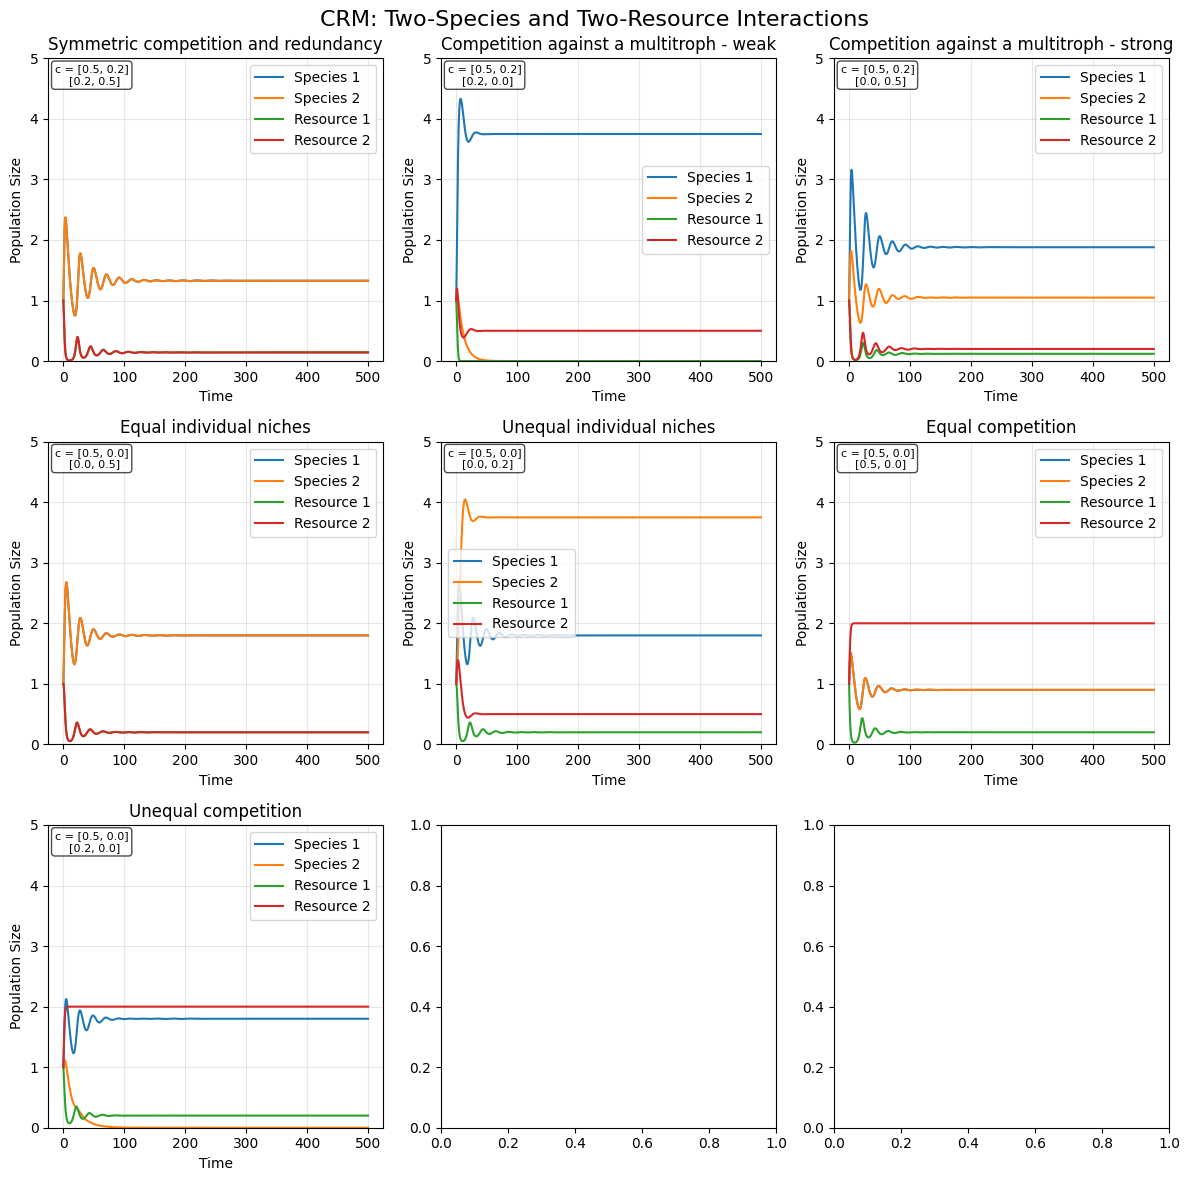

In [12]:
# CRM model implementation
def crm_model(t, y, tau, w, c, m, r, K):
    """
    Consumer Resource model

    Parameters:
    y: current state vector (species abundances)
    t: time
    tau: time constants
    w: resource uptake rates
    c: competition coefficients
    m: mortality rates
    r: intrinsic growth rates
    K: carrying capacities
    """
    x = np.array(y[:len(tau)])
    R = np.array(y[len(tau):])
    # Calculate dx/dt and dR/dt
    # dxdt = x / tau * (np.sum(w * c * R, axis=1) - m)
    dxdt = x / tau * (c @ (w * R) - m)
    # dRdt = r / K * R * (K - R) - np.sum(x * c * R, axis=1)
    dRdt = r / K * R * (K - R) - (x @ (c * R))

    return np.concatenate([dxdt, dRdt])

# Example 1: Two-species system with different interaction types
# Set up parameters for 2-species system
time_points = np.linspace(0, 500, 1001)
initial_conditions = [1.0, 1.0, 1.0, 1.0]  # Initial populations

# Create subplots for different scenarios
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('CRM: Two-Species and Two-Resource Interactions', fontsize=16)

for idx, (scenario_name, params) in enumerate(scenarios.items()):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    
    # Solve the CRM system
    solution = spi.solve_ivp(crm_model, (time_points[0], time_points[-1]), initial_conditions, 
                         args=(params['tau'], params['w'], params['c'], params['m'], params['r'], params['K']), 
                         t_eval=time_points, method='BDF')

    # Plot the trajectories
    ax.plot(solution.t, solution.y[0], label='Species 1')
    ax.plot(solution.t, solution.y[1], label='Species 2')    
    ax.plot(solution.t, solution.y[2], label='Resource 1')
    ax.plot(solution.t, solution.y[3], label='Resource 2')
    ax.set_title(f'{scenario_name}', fontsize=12)
    ax.set_xlabel('Time')
    ax.set_ylabel('Population Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # ax.set_ylim(0, max(2, np.max(solution) * 1.1))
    ax.set_ylim(0, 5)
    
    # Add annotation with consumption matrix c
    c_matrix = params['c']
    matrix_text = f"c = [{c_matrix[0,0]:.1f}, {c_matrix[0,1]:.1f}]\n    [{c_matrix[1,0]:.1f}, {c_matrix[1,1]:.1f}]"
    ax.text(0.02, 0.98, matrix_text, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()


## More complex mechanistic models

The models that we have shown so far are at a level of abstraction that allows for reasonably simple mathematical analysis of their behaviour. For example, the eignevalues of the gLV interaction matrix tell us about the structural stability of the system.

However, if we want to use our models to design a new community we need to be able to incorporate explicit terms for the interactions that we are engineering. In our work, this involves (1) keeping track of each molecular species that we deem important, (2) using saturating functions to model their effects on growth and death, and (3) implementing production terms for each species that may be dependent on other species (e.g. through quorum sensing).

In this workshop we won't use these models but I will leave it to you to explore their possibilities.